# More complex trough models
The previous notebooks used the most basic trough model, with a constant lag $l(t) = l_0$ and an accumulation that is a linear function of the insolation $A(t) = aI(t)$. The next most complicated models can either make the lag linear in time or making the accumulation quadratic in insolation: $l(t) = l_0 + l_1t$ and $A(t) = aI + bI^2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mars_troughs as mt
import scipy.optimize as op
import emcee, corner
%matplotlib inline

In [2]:
plt.rc("font", size=14, family="serif")
#plt.rc("text", usetex=True) #uncomment when we are ready to make final figures

In [3]:
test_acc_params = [1e-6, 1e-11]
acc_model_number = 1
test_lag_params = [1]
lag_model_number = 0
errorbar = 1.
tr = mt.Trough(test_acc_params, test_lag_params,
                acc_model_number, lag_model_number,
                errorbar)

In [4]:
#Define the log likelihood
def ln_likelihood(params):
    variance = params[0]
    if variance < 0:
        return -1e99
    acc_params = np.array([params[1:3]]).flatten()
    lag_params = np.array([params[3]])
    tr.set_model(acc_params, lag_params, np.sqrt(variance))
    if any(tr.lags_t < 0) or any(tr.lags_t > 20):
        #print("here")
        #print(tr.lags_t)
        return -1e99
    tr.compute_splines()
    return tr.lnlikelihood()

#And the negative of the log likelihood
def neg_ln_likelihood(params):
    return -ln_likelihood(params)

In [5]:
guess = [errorbar**2, test_acc_params[0], test_acc_params[1], 
         test_lag_params[0]]
result = op.minimize(neg_ln_likelihood, x0=guess, method='Nelder-Mead')
print(result)

 final_simplex: (array([[1.84864453e+00, 5.54574685e-07, 1.14290593e-11, 6.55360018e-01],
       [1.84866931e+00, 5.54574511e-07, 1.14290718e-11, 6.55345726e-01],
       [1.84872818e+00, 5.54574184e-07, 1.14290594e-11, 6.55307639e-01],
       [1.84873465e+00, 5.54573956e-07, 1.14290943e-11, 6.55304789e-01],
       [1.84874274e+00, 5.54573851e-07, 1.14290938e-11, 6.55299462e-01]]), array([172.95450296, 172.95450749, 172.95451768, 172.95452018,
       172.95452204]))
           fun: 172.9545029573999
       message: 'Optimization terminated successfully.'
          nfev: 221
           nit: 113
        status: 0
       success: True
             x: array([1.84864453e+00, 5.54574685e-07, 1.14290593e-11, 6.55360018e-01])


In [6]:
#Set the model to the best model
best = result['x']
variance = best[0]
acc_params = np.array([best[1:3]]).flatten()
lag_params = np.array([best[3]]).flatten()
tr.set_model(acc_params, lag_params, np.sqrt(variance))

('Errorbars in meters: ', 679.8243402019664, 27.192973608078653)


(-505.53, 30)

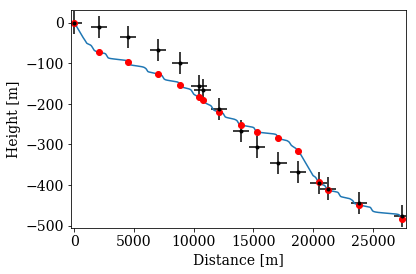

In [7]:
#Compare the trajectory with data
times = tr.ins_times
plt.plot(tr.get_xt(times), tr.get_yt(times))
xerr, yerr = tr.errorbar*tr.meters_per_pixel
print("Errorbars in meters: ", xerr, yerr)
plt.errorbar(x=tr.xdata, xerr=xerr, y=tr.ydata, yerr=yerr, c='k', marker='.', ls='')
xn,yn = tr.get_nearest_points()
plt.plot(xn, yn, ls='', marker='o', c='r')
plt.xlabel(r"Distance [m]")
plt.ylabel(r"Height [m]")
xlim = [np.min(tr.xdata)-300, np.max(tr.xdata)+300] #meters
ylim = [np.min(tr.ydata)-30, 30]
plt.xlim(xlim)
plt.ylim(ylim)

In [8]:
ndim = len(result.x)
nwalkers = ndim*4
nburn = 200
nsteps = 2000
p0 = [result.x + 1e-3*result.x*np.random.randn(ndim) for i in range(nwalkers)]

In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood)
_ = sampler.run_mcmc(p0, nburn)

In [10]:
p0 = sampler.chain[:,-1]
sampler.reset()
_ = sampler.run_mcmc(p0, nsteps)
chain = sampler.flatchain

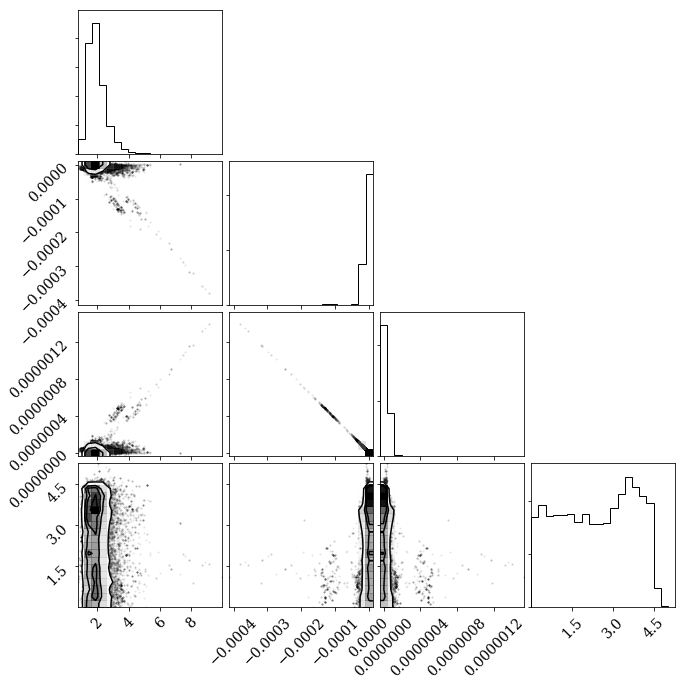

In [11]:
fig = corner.corner(chain)

[ 1.35208324e+00 -1.14715451e-05  4.43239700e-08  3.17912303e+00]
('Errorbars in meters: ', 581.3955702618888, 23.255822810475554)


(-505.53, 30)

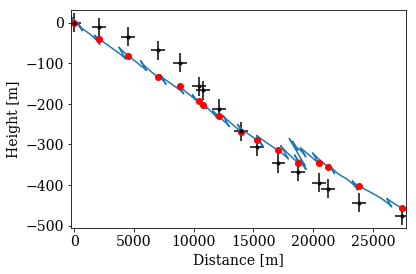

In [13]:
#Set the model to the best model
best = chain[np.argmax(sampler.flatlnprobability)]
variance = best[0]
acc_params = np.array([best[1], best[2]])
lag_params = np.array([best[3]])
print(best)
tr.set_model(acc_params, lag_params, np.sqrt(variance))
#Compare the trajectory with data
times = tr.ins_times
plt.plot(tr.get_xt(times), tr.get_yt(times))
xerr, yerr = tr.errorbar*tr.meters_per_pixel
print("Errorbars in meters: ", xerr, yerr)
plt.errorbar(x=tr.xdata, xerr=xerr, y=tr.ydata, yerr=yerr, c='k', marker='.', ls='')
xn,yn = tr.get_nearest_points()
plt.plot(xn, yn, ls='', marker='o', c='r')
plt.xlabel(r"Distance [m]")
plt.ylabel(r"Height [m]")
plt.xlim(xlim)
plt.ylim(ylim)

Something clearly goes wrong with the interpolator, since the trough moves backwards which should never happen...